In [1]:
from tensorflow.keras.datasets import mnist
import sys

from tqdm import tqdm
from torch import optim
from torch.nn import functional as f
from torch import nn
import torch
import matplotlib.pyplot as plt
import math

In [2]:
N_EPOCHS = 40
batch_size = 64

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/ 255
X_test = X_test / 255




y_test = torch.LongTensor(y_test)
X_train = torch.Tensor(X_train).unsqueeze(1)
y_train = torch.LongTensor(y_train)
X_test = torch.Tensor(X_test).unsqueeze(1)
X_train.shape, X_test.shape

train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

In [3]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [4]:
device = 'cuda'

In [5]:
class TimeEmb(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, n_channels)
        self.selu = nn.SELU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, time):
        half_dim = self.n_channels // 8
        const = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=time.device) * -const)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.lin2(self.selu(self.lin1(emb)))
        return emb


class ResBlock(nn.Module):
    # No really res net block since we change outputs
    def __init__(self, in_channels, out_channels, time_channels, n_groups=8, dropout=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.selu1 = nn.SELU()
        self.selu2 = nn.SELU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_selu = nn.SELU()
        self.dropout = nn.Dropout(dropout)

        if in_channels != out_channels:
            self.shorcut = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        else:
            self.shorcut = nn.Identity()


    def forward(self, x, t):
        h = self.conv1(self.selu1(self.norm1(x)))
        h = h + self.time_emb(self.time_selu(t))[:, :, None, None]
        h = self.conv2(self.selu2(self.norm2(h)))
        return self.shorcut(x) + h


class UpSamplingBlock(nn.Module):
    def __init__(self, up_channels, in_channels, out_channels, time_channels):
        super().__init__()
        self.res = ResBlock(in_channels, out_channels, time_channels)
        self.upconv = nn.ConvTranspose2d(up_channels, up_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x, x_d, t):
        h = self.upconv(x)
        h = torch.concat((h, x_d), 1)
        h = self.res(h, t)
        return h


class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels):
        super().__init__()
        self.res = ResBlock(in_channels, out_channels, time_channels)
        self.downconv = nn.Conv2d(out_channels, out_channels, (2, 2), (2, 2))

    def forward(self, x, t):
        h = self.res(x, t)
        h_d = self.downconv(h)
        return h, h_d


class UNetSimple(nn.Module):
    def __init__(self, image_channels=1, n_channels=64):
        super().__init__()
        self.init_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmb(n_channels * 4)

        self.down1 = DownSamplingBlock(n_channels, 1 * n_channels, 4 * n_channels)
        self.down2 = DownSamplingBlock(n_channels, 2 * n_channels, 4 * n_channels)

        self.bottle_neck = ResBlock(2 * n_channels, 2 * n_channels, 4 * n_channels)

        self.up1 = UpSamplingBlock(2 * n_channels, 4 * n_channels, 2 * n_channels, 4 * n_channels)
        self.up2 = UpSamplingBlock(2 * n_channels, 3 * n_channels, 1 * n_channels, 4 * n_channels)

        self.norm = nn.GroupNorm(8, n_channels)
        self.selu = nn.SELU()
        self.out = nn.Conv2d(n_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x, t):
        h = self.init_proj(x)
        t_emb = self.time_emb(t)
        h0, h = self.down1(h, t_emb)
        h1, h = self.down2(h, t_emb)
        h = self.bottle_neck(h, t_emb)
        h = self.up1(h, h1, t_emb)
        h = self.up2(h, h0, t_emb)
        return self.out(self.selu(self.norm(h)))

In [6]:
class DDM:

    def __init__(self, eps_model, n_steps = 1000, device='cpu'):
        self.eps_model = eps_model.to(device)
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = (1. - self.beta).to(device)
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(device)

        self.n_steps = n_steps
        self.sigma2 = self.beta

    def q_xt_x0(self, x0, t):

        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        #
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        # [gather](utils.html) $\bar\alpha_t$
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)

        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)
        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** .5) * eps


    def loss(self, x0: torch.Tensor, noise = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0, device=x0.device)
        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)

        return f.mse_loss(noise, eps_theta)


loss_item=0.014547386206686497: 100%|██████████| 40/40 [35:45<00:00, 53.63s/it]


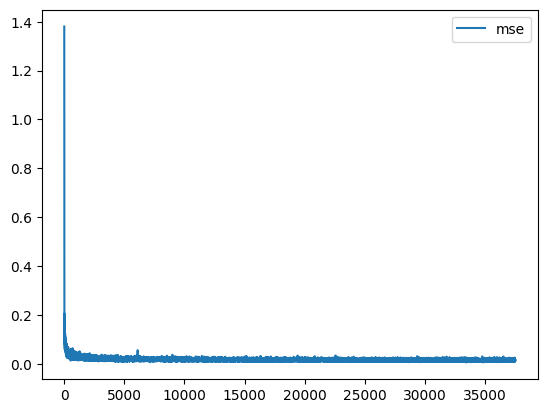

In [7]:
eps_model = UNetSimple(n_channels=64)
dif_model = DDM(eps_model, device=device)

opt = optim.Adam(eps_model.parameters(), lr=1e-4)
losses = []


for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        opt.zero_grad()
        loss = dif_model.loss(data)
        loss.backward()
        opt.step()
        loss_item = loss.detach().cpu().item()
        losses.append(loss_item)
    pbar.set_description(f'{loss_item=}')


plt.plot(losses, label='mse')
plt.legend();


In [11]:
n_samples = 10

with torch.no_grad():
    # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
    x = torch.randn([n_samples, 1, 28, 28], device=device)

    # Remove noise for $T$ steps
    for t_ in range(1_000):
        # $t$
        t = 1000 - t_ - 1
        x = dif_model.p_sample(x, x.new_full((1,), t, dtype=torch.long))



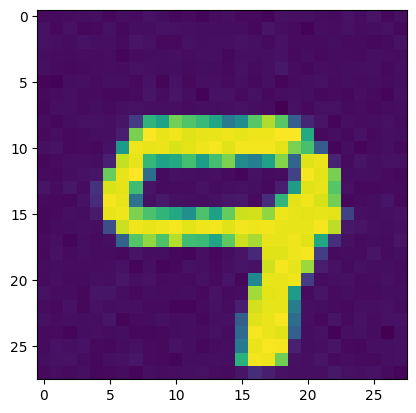

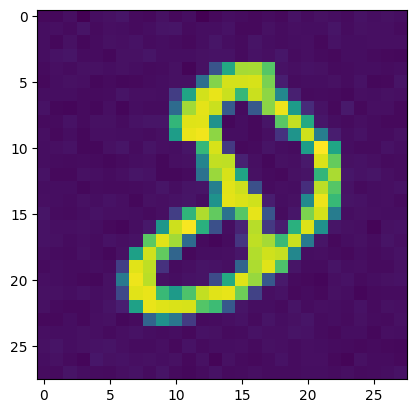

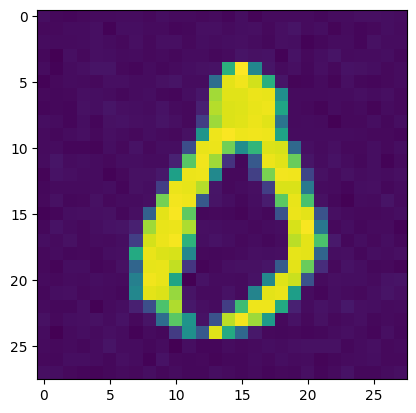

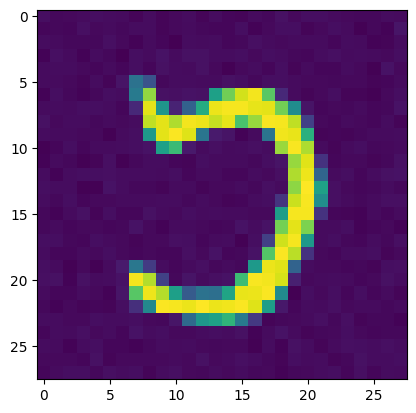

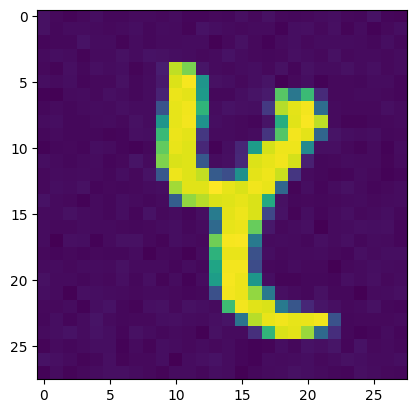

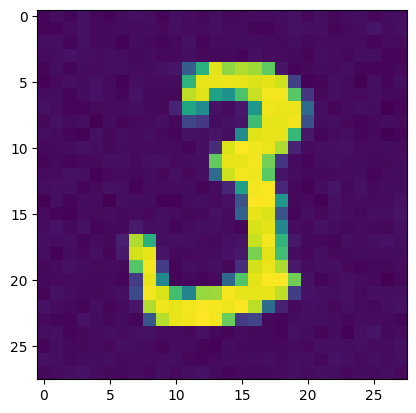

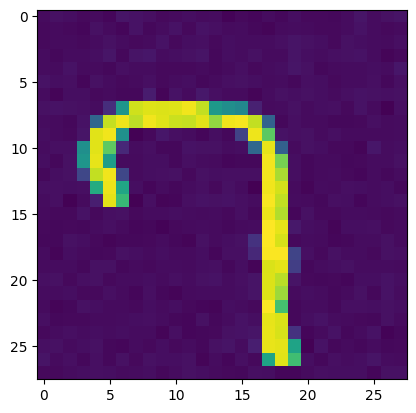

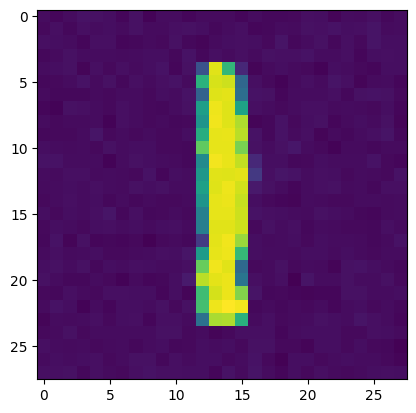

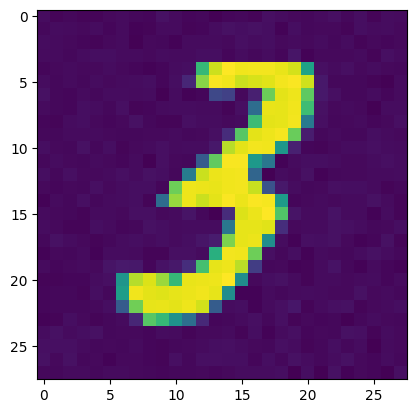

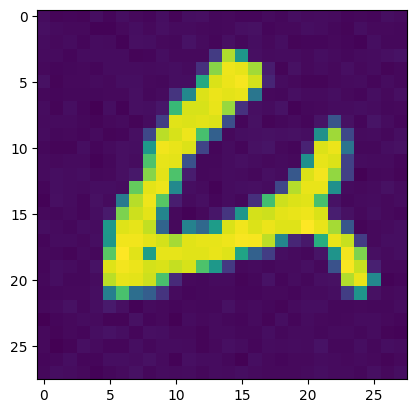

In [12]:
x = x.cpu().numpy()
for i in range(n_samples):
  plt.imshow(x[i][0])
  plt.show()